# 02 - Modeling: Multi-Label Posture Classification

**Objective**: Build a model to automate procedural posture labeling and analyze feasibility.

**Approach**:
1. TF-IDF + Logistic Regression baseline
2. Comprehensive evaluation (overall + per-class)
3. Feasibility recommendation comparing to human annotator agreement (κ = 0.63–0.93)

In [ ]:
import sys
sys.path.insert(0, '..')

from src.data_loader import DataLoader
from src.model_trainer import DataPreparer, BaselineTrainer
from src.model_evaluator import MultiLabelEvaluator, compute_threshold_analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', 50)

## 1. Data Preparation

In [5]:
# Load data
loader = DataLoader('../data/TRDataChallenge2023.txt')

# Prepare: extract text, encode labels, split, vectorize
# min_label_count=50 filters to labels with sufficient training samples
preparer = DataPreparer(loader, min_label_count=50, random_state=42)
data = preparer.prepare(max_features=10000, ngram_range=(1, 2))

print(data.summary())
print(f"\nLabels used: {len(data.label_names)}")

PREPARED DATA SUMMARY
Train samples:     11,708
Validation samples:2,509
Test samples:      2,510
Number of labels:  41
Feature dimension: 10000

Labels used: 41


## 2. Baseline Model: TF-IDF + Logistic Regression

In [6]:
# Train baseline
trainer = BaselineTrainer(C=1.0, max_iter=1000)
trainer.train(data.X_train, data.y_train)

# Predict on test set
y_pred = trainer.predict(data.X_test)
y_proba = trainer.predict_proba(data.X_test)

print("Training complete.")

/opt/homebrew/anaconda3/envs/tr_challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/anaconda3/envs/tr_challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/anaconda3/envs/tr_challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/anaconda3/envs/tr_challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' h

Training complete.


## 3. Evaluation

In [7]:
# Evaluate
evaluator = MultiLabelEvaluator(data.label_names)
results = evaluator.evaluate(data.y_test, y_pred)

print(results.summary())

MULTI-LABEL EVALUATION RESULTS

Overall Metrics:
  F1 Micro:          0.7516
  F1 Macro:          0.5257
  F1 Weighted:       0.7981
  F1 Samples:        0.7685

  Precision (micro): 0.6474
  Precision (macro): 0.4313
  Recall (micro):    0.8959
  Recall (macro):    0.7486

  Hamming Loss:      0.0227
  Exact Match Ratio: 0.4120


In [8]:
# Top 10 best performing classes
print("TOP 10 CLASSES (by F1):")
results.get_top_classes(10, 'f1')[['label', 'precision', 'recall', 'f1', 'support']]

TOP 10 CLASSES (by F1):


,label,precision,recall,f1,support
1,Appellate Review,0.920657,0.976778,0.947887,689
0,On Appeal,0.919573,0.924839,0.922198,1397
2,Review of Administrative Decision,0.823529,0.954545,0.884211,396
8,Motion for Preliminary Injunction,0.836066,0.927273,0.879310,55
38,Motion to Disqualify Counsel,0.750000,1.000000,0.857143,6
12,Motion to Compel Arbitration,0.720930,0.939394,0.815789,33
11,Motion to Dismiss for Lack of Personal Jurisdi...,0.720930,0.885714,0.794872,35
6,Motion for Attorney's Fees,0.650685,0.855856,0.739300,111
22,Motion for Contempt,0.571429,0.941176,0.711111,17
4,Sentencing or Penalty Phase Motion or Objection,0.581250,0.902913,0.707224,206


In [9]:
# Bottom 10 worst performing classes
print("BOTTOM 10 CLASSES (by F1):")
results.get_bottom_classes(10, 'f1')[['label', 'precision', 'recall', 'f1', 'support']]

BOTTOM 10 CLASSES (by F1):


,label,precision,recall,f1,support
40,Motion for Restraining or Protection Order,0.090909,0.500000,0.153846,4
34,Motion for Permanent Injunction,0.102564,0.444444,0.166667,9
26,Motion to Set Aside or Vacate,0.111111,0.384615,0.172414,13
21,Motion to Dismiss for Lack of Jurisdiction,0.137931,0.421053,0.207792,19
31,Motion to Stay Proceedings,0.150000,0.600000,0.240000,10
37,Motion for Relief from Order or Judgment,0.200000,0.428571,0.272727,7
35,Motion to Strike All or Part of a Pleading,0.172414,0.714286,0.277778,7
32,Motion for Extension of Time,0.222222,0.400000,0.285714,10
27,Petition for Custody,0.192982,0.916667,0.318841,12
16,Motion for Reconsideration,0.223881,0.555556,0.319149,27


## 4. Threshold Analysis

In [10]:
# Analyze threshold impact
thresh_df = compute_threshold_analysis(data.y_test, y_proba, data.label_names)
thresh_df

,threshold,f1_micro,f1_macro,precision,recall
0,0.1,0.392355,0.231987,0.244980,0.984772
1,0.2,0.555620,0.348854,0.389547,0.968528
2,0.3,0.649761,0.424935,0.493861,0.949492
3,0.4,0.711715,0.481904,0.578906,0.923604
4,0.5,0.751624,0.525662,0.647350,0.895939
5,0.6,0.772857,0.556494,0.703688,0.857107
6,0.7,0.777956,0.561349,0.758006,0.798985
7,0.8,0.755345,0.567367,0.808986,0.708376
8,0.9,0.660012,0.508720,0.855987,0.537056


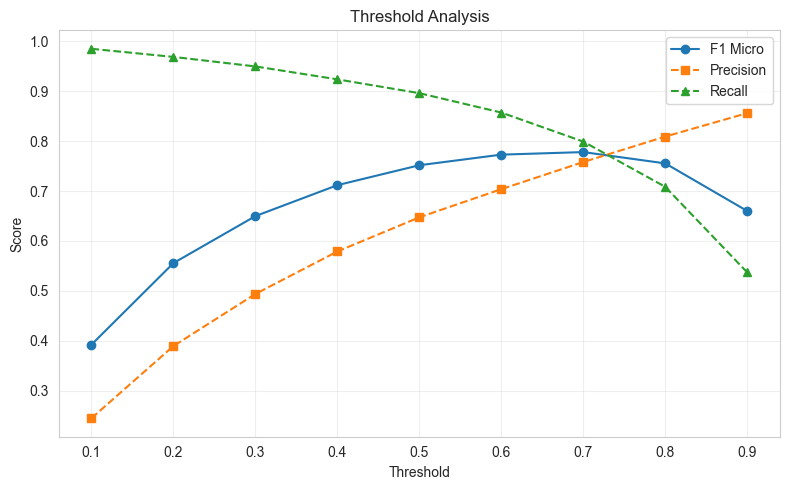

In [11]:
# Plot threshold analysis
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(thresh_df['threshold'], thresh_df['f1_micro'], 'o-', label='F1 Micro')
ax.plot(thresh_df['threshold'], thresh_df['precision'], 's--', label='Precision')
ax.plot(thresh_df['threshold'], thresh_df['recall'], '^--', label='Recall')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Threshold Analysis')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Feasibility Analysis

In [12]:
# Compare to human annotator agreement (κ = 0.63–0.93)
feasibility = results.get_feasibility_analysis(human_kappa_low=0.63, human_kappa_high=0.93)

print(f"Postures feasible for automation (F1 ≥ 0.63): {feasibility['automation_feasible'].sum()}")
print(f"High confidence automation (F1 ≥ 0.93):       {feasibility['high_confidence'].sum()}")
print(f"Needs human review (0.50 ≤ F1 < 0.63):        {feasibility['needs_review'].sum()}")

# Show automatable postures
print("\nFEASIBLE FOR AUTOMATION:")
feasibility[feasibility['automation_feasible']][['label', 'f1', 'support']].head(15)

Postures feasible for automation (F1 ≥ 0.63): 14
High confidence automation (F1 ≥ 0.93):       1
Needs human review (0.50 ≤ F1 < 0.63):        7

FEASIBLE FOR AUTOMATION:


,label,f1,support
0,On Appeal,0.922198,1397
1,Appellate Review,0.947887,689
2,Review of Administrative Decision,0.884211,396
4,Sentencing or Penalty Phase Motion or Objection,0.707224,206
6,Motion for Attorney's Fees,0.739300,111
8,Motion for Preliminary Injunction,0.879310,55
11,Motion to Dismiss for Lack of Personal Jurisdi...,0.794872,35
12,Motion to Compel Arbitration,0.815789,33
17,Petition to Terminate Parental Rights,0.650602,27
19,Juvenile Delinquency Proceeding,0.636364,20


In [13]:
# Performance by support tier
per_class = results.per_class_metrics.copy()
per_class['tier'] = pd.cut(
    per_class['support'],
    bins=[0, 50, 100, 500, 1000, float('inf')],
    labels=['<50', '50-100', '100-500', '500-1000', '1000+']
)

tier_summary = per_class.groupby('tier', observed=True).agg({
    'f1': ['mean', 'std'],
    'label': 'count'
}).round(3)
tier_summary.columns = ['F1 Mean', 'F1 Std', 'Count']
tier_summary

,F1 Mean,F1 Std,Count
tier,,,
<50,0.467,0.199,32
50-100,0.602,0.392,2
100-500,0.708,0.116,5
500-1000,0.948,NaN,1
1000+,0.922,NaN,1


## 6. Business Recommendation

**Summary of findings to be written after running the notebook.**

In [14]:
# Summary statistics for recommendation
print("=" * 60)
print("SUMMARY FOR BUSINESS RECOMMENDATION")
print("=" * 60)
print(f"\nModel Performance:")
print(f"  F1 Micro:    {results.f1_micro:.3f}")
print(f"  F1 Macro:    {results.f1_macro:.3f}")
print(f"  F1 Weighted: {results.f1_weighted:.3f}")
print(f"\nHuman Annotator Agreement: κ = 0.63–0.93")
print(f"\nAutomation Feasibility:")
print(f"  Fully automatable:  {feasibility['automation_feasible'].sum()} / {len(feasibility)} postures")
print(f"  High confidence:    {feasibility['high_confidence'].sum()} / {len(feasibility)} postures")
print(f"  Needs review:       {feasibility['needs_review'].sum()} / {len(feasibility)} postures")
print("=" * 60)

SUMMARY FOR BUSINESS RECOMMENDATION

Model Performance:
  F1 Micro:    0.752
  F1 Macro:    0.526
  F1 Weighted: 0.798

Human Annotator Agreement: κ = 0.63–0.93

Automation Feasibility:
  Fully automatable:  14 / 41 postures
  High confidence:    1 / 41 postures
  Needs review:       7 / 41 postures
